
## 传统动量策略
$$r^{TSMOM,i}_{t,t+1}=sgn(r^{i}_{t-252,t})\frac{\sigma_{tgt}}{\sigma^{i}_{t}}r^{i}_{t,t+1} \tag{1}$$
$$sgn(x):=\begin{cases}1\ if\ x>0,\\
                       0\ if\ x=0, \\
                      -1\ if\ x<0
            \end{cases} \tag{2}$$

其中:
$r^{i}_{t-252,t}$为资产i,t时刻过去一年的收益率;$r^{i}_{t,t+1}$为资产i,t时刻的收益率;$\sigma_{tgt}$目标年化波动率;$\sigma^{i}_{t}$资产i的历史波动率,计算窗口期为60日,使用指数衰减权重计算。

最终资产组合可以表达为:
$$r^{TSMOM}_{t,t+1}=\frac{1}{S_t}\sum^{S_t}_{i=1}r^{TSMOM,i}_{t,t+1} \tag{3}$$

其中:$S_t$为组合在t时刻的标的数量

## 模型架构
![avatar](./img/mtl%20model.png)

## 时序动量组合

从上文的基于*目标波动率*的传统时序动量策略可以看出,确定每只股票权重有两个因素:动量的方向和股票的波动率。在主要任务钟,我们直接预测股票权重,那么组合的收益率就由上面的上式变为以下等式:
$$r^{\rho}_{t,t+1}=\frac{\sigma_{tgt}}{S_t}\sum^{S_t}_{i=1}\omega^{i}_{t-1,t}r^{i}_{t,t+1} \tag{4}$$

为了控制交易换手,加入惩罚项:

$$r^{\rho}_{t,t+1}=\frac{\sigma_{tgt}}{S_t}\sum^{S_t}_{i=1}\omega^{i}_{t-1,t}r^{i}_{t,t+1}-\tau|\omega^{i}_{t-1,t}-\omega^{i}_{t-2,t-1}| \tag{5}$$

其中:$\tau$为交易手续费,默认设置为3bps,$|\omega^{i}_{t-1,t}-\omega^{i}_{t-2,t-1}|$为资产组合S在t时刻到t+1时刻的权重变化

目标函数(损失函数):
$$L_{SharpeRatio}=-\frac{\mathbb{E}[r^{\rho}]}{\sigma_{r^{\rho}}} \tag{6}$$


## 特征生成

1. Close-to-close volatility estimator,$\sigma_{ctc}$
2. Parkinson volatility estimator, $\sigma_{\rho}$ (Parkinson, 1980)
3. Garman-Klass volatility estimator, $\sigma_{gk}$ (Garman & Klass, 1980)
4. Rogers-Satchell volatility estimator, $\sigma_{rs}$ (Rogers & Satchell, 1991)
5. Yang-Zhang volatility estimator, $\sigma_{yz}$ (Yang & Zhang, 2000)

### 公式

公式参考:
> Exploring the predictability of range-based volatility estimators using RNNs

[volatility-trading](https://github.com/jasonstrimpel/volatility-trading/tree/master/volatility/models)

Close-to-close volatility:$\sqrt{\frac{1}{N-1}\sum^{T}_{i=1}(ln(\frac{c_i}{c_{i-1}}-\overline{\frac{c_t}{c_{t-1}}})^2)}$

Parkinson volatility:$\sqrt{\frac{1}{4Tln2}\sum^{T}_{i=1}(ln\frac{h_{i}}{l_{i}})^2}$

Garman-Klass Volatility:$\sqrt{\frac{1}{T}\sum^{T}_{i=1}(0.5*ln(\frac{h_{i}}{l_{i}})^2-(2ln(2)-1)ln(\frac{c_i}{o_{i}})^2)}$

Rogers-Satchell Volatility:$\sqrt{\frac{1}{T}\sum^{T}_{i=1}(ln(\frac{h_i}{o_i})(ln(\frac{h_i}{o_i})-ln(\frac{c_i}{o_i}))+ln(\frac{l_i}{o_i})(ln(\frac{l_i}{o_i})-ln(\frac{c_i}{o_i}))}$

Yang-Zhang volatility:

$\sqrt{\frac{1}{N-1}\sum^{T}_{i=1}(ln(\frac{o_i}{c_{i-1}})-\overline{ln(\frac{o_i}{c_{i-1}})})^2+\frac{k}{N-1}\sum^{T}_{i=1}(ln(\frac{c_i}{o_{i-1}})-\overline{ln(\frac{c_i}{o_{i-1}})})^2+(1-k)V_{RS}}$

其中:
$k=\frac{0.34}{1.34+\frac{N+1}{N-1}}$

$V_{RS}=\frac{1}{N}\sum^{N}_{i=1}(ln(\frac{h_i}{o_i})(ln(\frac{h_i}{o_i})-ln(\frac{c_i}{o_i}))+ln(\frac{l_i}{o_i})(ln(\frac{l_i}{o_i})-ln(\frac{c_i}{o_i})))$

$o_{i},c_{i},h_{i},l_{i}$分别为i时刻的OHLC数据

特征部分的损失函数就是最小化已实现波动率与预测波动率之间的负相关系数:
$$L_{corr(y,\hat{y})}=-\frac{S_{y,\hat{y}}}{S_{y}*S_{\hat{y}}} \tag{7}$$

整体任务的损失函数

$$L_{total}=-\mu\frac{\mathbb{E}[r^{\rho}]}{\sigma_{r^{\rho}}}+\lambda\sum_{h \in H}-\frac{S_{y_{h},\hat{y_{h}}}}{S_{y_{h}}\cdot S_{\hat{y_h}}}$$

其中$\mu$和$\lambda$为权重,取值在[0,1]之间,$\mu+\lambda=1$,这里进行简单处理$\mu=0.5,\lambda=0.5$

In [1]:
from typing import Dict

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from src.core import MTL_TSMOM
from src.general import get_backtest_metrics, get_strategy_returns
from src.data_processor import DataProcessor
from src.utils import plot_pred_nan_num

plt.rcParams["font.sans-serif"] = ["simhei"]  # 解决中文乱码
plt.rcParams["axes.unicode_minus"] = False

## 数据读取

这里我们使用的标的为:黄金ETF(518880.SH)、纳指ETF(513100.SH)、创业板ETF(159915.SZ)、沪深300ETF(510300.SH),时间范围2014-01-01至2023-08-02,价格数据后复权

In [2]:
test_size: int = 1  # 测试集
basic_rate: float = 0.6  # 训练集占比
standardize_window: int = 21  # 标准化窗口
vol_forward_window: int = 21  # 预测未来波动率的窗口

dataset = DataProcessor()
dataset.generate(
    standardize_window=standardize_window,
    vol_forward_window=vol_forward_window,
    vol_method="CTC",  # vr波动使用CTC计算
    return_method="OTO",  # return使用OTO计算
)
dataset.build_dataset(test_size=test_size, valid_ratio=0.2, base_ratio=basic_rate)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=924, test_size=1)


In [4]:
total_szie: int = dataset.frame.index.levels[1].size

print(
    f"时间序列长度{total_szie},起始长度{basic_rate*100}%,基础长度为{int(total_szie*basic_rate)},n_splits为{(total_szie*(1-basic_rate))//test_size}"
)


时间序列长度2311,起始长度60.0%,基础长度为1386,n_splits为924.0


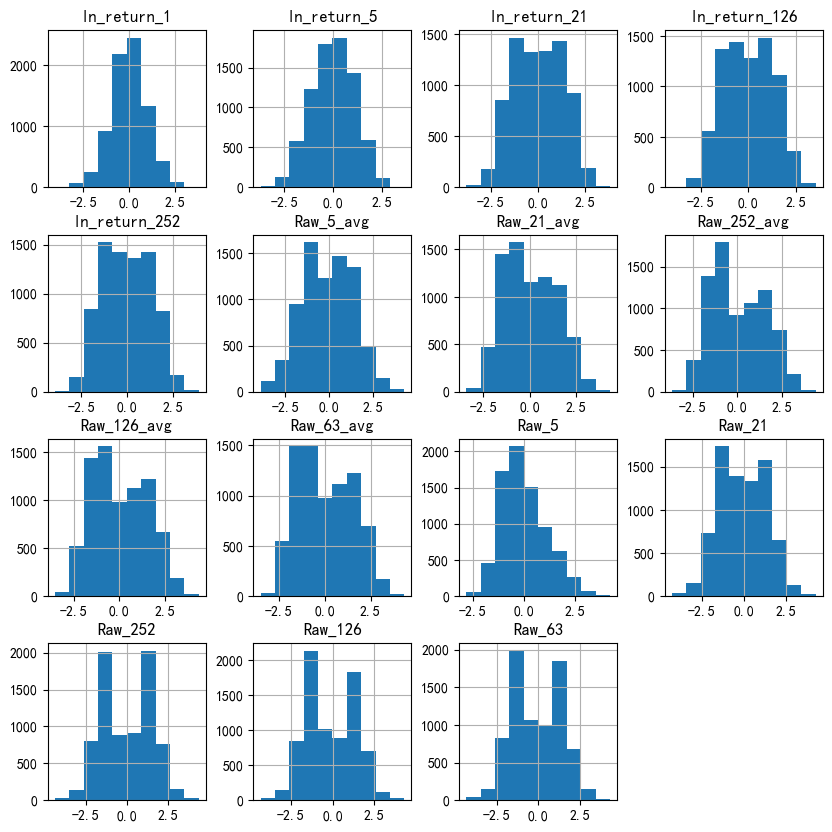

In [5]:
dataset.frame['features_fields'].dropna().hist(figsize=(10, 10));

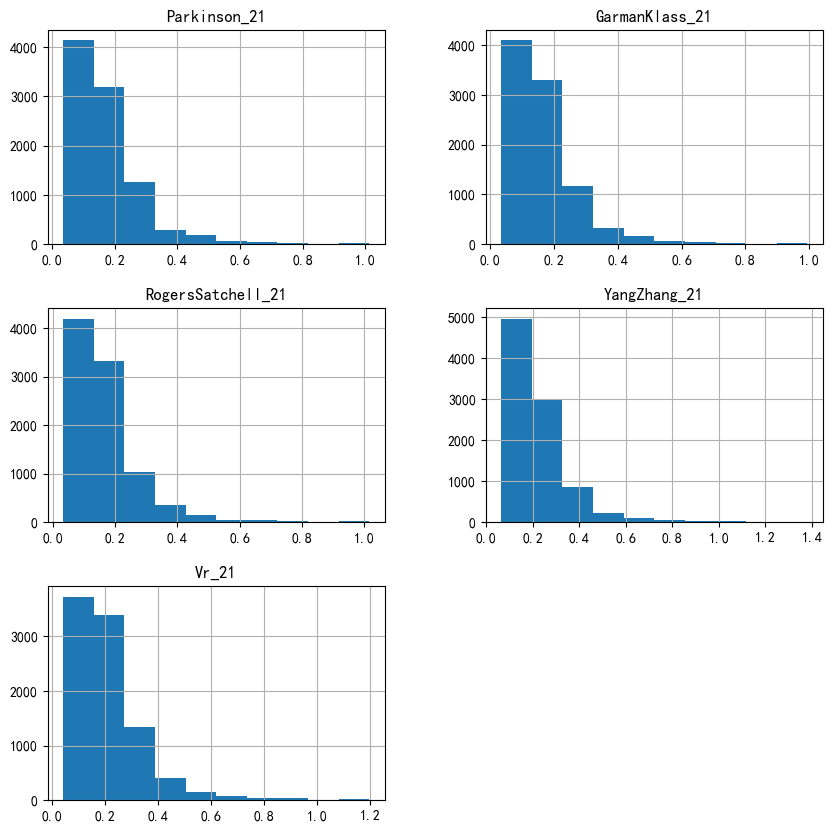

In [6]:
dataset.frame['auxiliary_fields'].dropna().hist(figsize=(10, 10));

In [15]:
lr: float = 0.0001
params: Dict = dict(
    dataset=dataset,
    input_size=15,  # 特征维度
    lstm_hidden_size=128,
    mpl_hidden_size=256,
    lstm_layers=2,
    mpl_layers=3,
    lstm_dropout=0.2,
    mpl_dropout=0.15,
    max_grad_norm=0.1,
    num_epochs=100,
    transcation_cost=0.0003,  # 交易成本
    target_vol=0.3,  # 目标波动率
    early_stopping=25,
    optimizer_name="Adam",  # 优化器
    opt_kwargs=dict(lr=lr),  # 优化器参数
    verbose=False,
)
# 预测的权重及未来的OTO收益
mtl_tsmom = MTL_TSMOM(**params)
mtl_tsmom.fit()

train: 100%|██████████| 924/924 [09:59<00:00,  1.54it/s]


[]

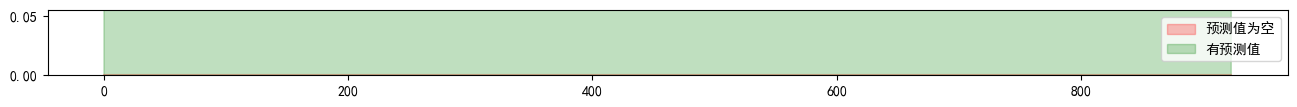

In [16]:
# 检查是否有数据缺失
loss_score_frame:pd.DataFrame = mtl_tsmom.plot_pred_nan_num()
loss_score_frame.plot(title='loss_score')

<Axes: title={'center': 'Loss Score'}>

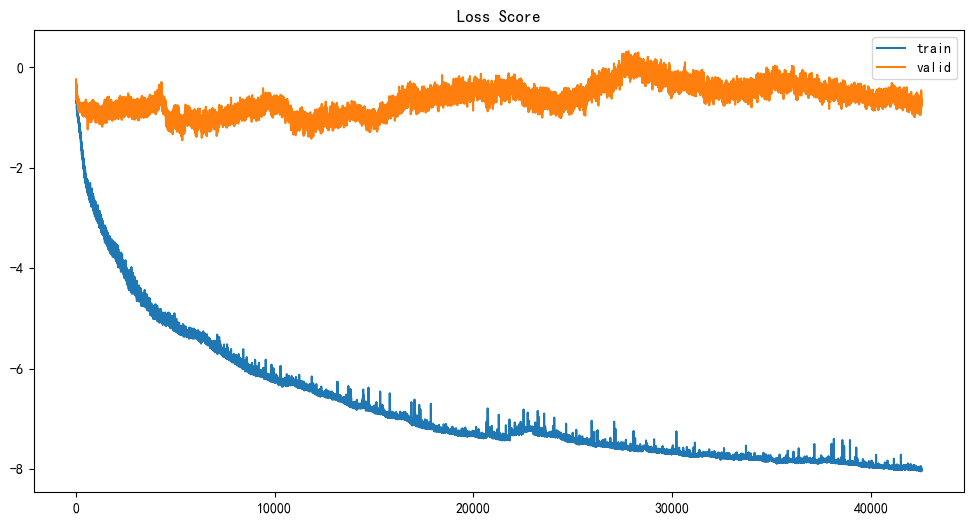

In [17]:
mtl_tsmom.get_loss_score().plot(figsize=(12, 6), title='Loss Score')

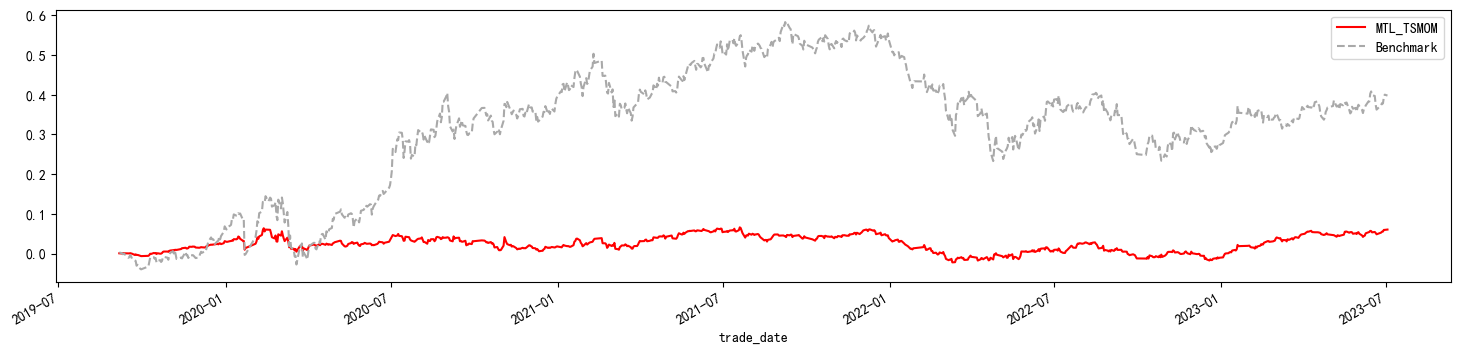

In [18]:
# strategy_frame: pd.DataFrame = get_strategy_returns(
#     weights, next_ret, dataset.test_idx)
strategy_frame: pd.DataFrame = mtl_tsmom.get_backtest_returns()
strategy_cum: pd.DataFrame = ep.cum_returns(strategy_frame)
ax = strategy_cum.plot(figsize=(18, 4), y="MTL_TSMOM", color="r")
strategy_cum.plot(ax=ax, y="Benchmark", label="Benchmark",
                  ls="--", color="darkgray")
plt.legend()

In [19]:
strategy_frame.apply(lambda x: get_backtest_metrics(x)['metrics'])

,MTL_TSMOM,Benchmark
Annualized Return,0.016114,0.095707
Cumulative Return,0.060365,0.398124
Annualized Sharpe Ratio,0.300175,0.617428
Annualized Sortino Ratio,0.419656,0.869483
Max Drawdown,-0.082806,-0.221324
Annualized volatility,0.059062,0.172100


# 超参

In [3]:
from src.optimize_multi_model import optimize_multi_hyperparameters

In [20]:
study = optimize_multi_hyperparameters(dataset,batch_size=200,early_stopping=50,target_vol=0.5,n_trials=20)

[I 2023-08-08 21:45:33,747] A new study created in memory with name: no-name-acfc88e5-cc6c-4a98-9631-e3b0cbcfbf3d


In [5]:
study.best_trial.params

{'lstm_layers': 2,
 'mpl_layers': 3,
 'hidden_size': 128,
 'ff_hidden_size': 256,
 'lstm_dropout': 0.2,
 'mpl_dropout': 0.15,
 'max_grad_norm': 0.1,
 'lr': 0.1,
 'optimizer': 'Adam'}